## Natural Language Processing with Disaster Tweets


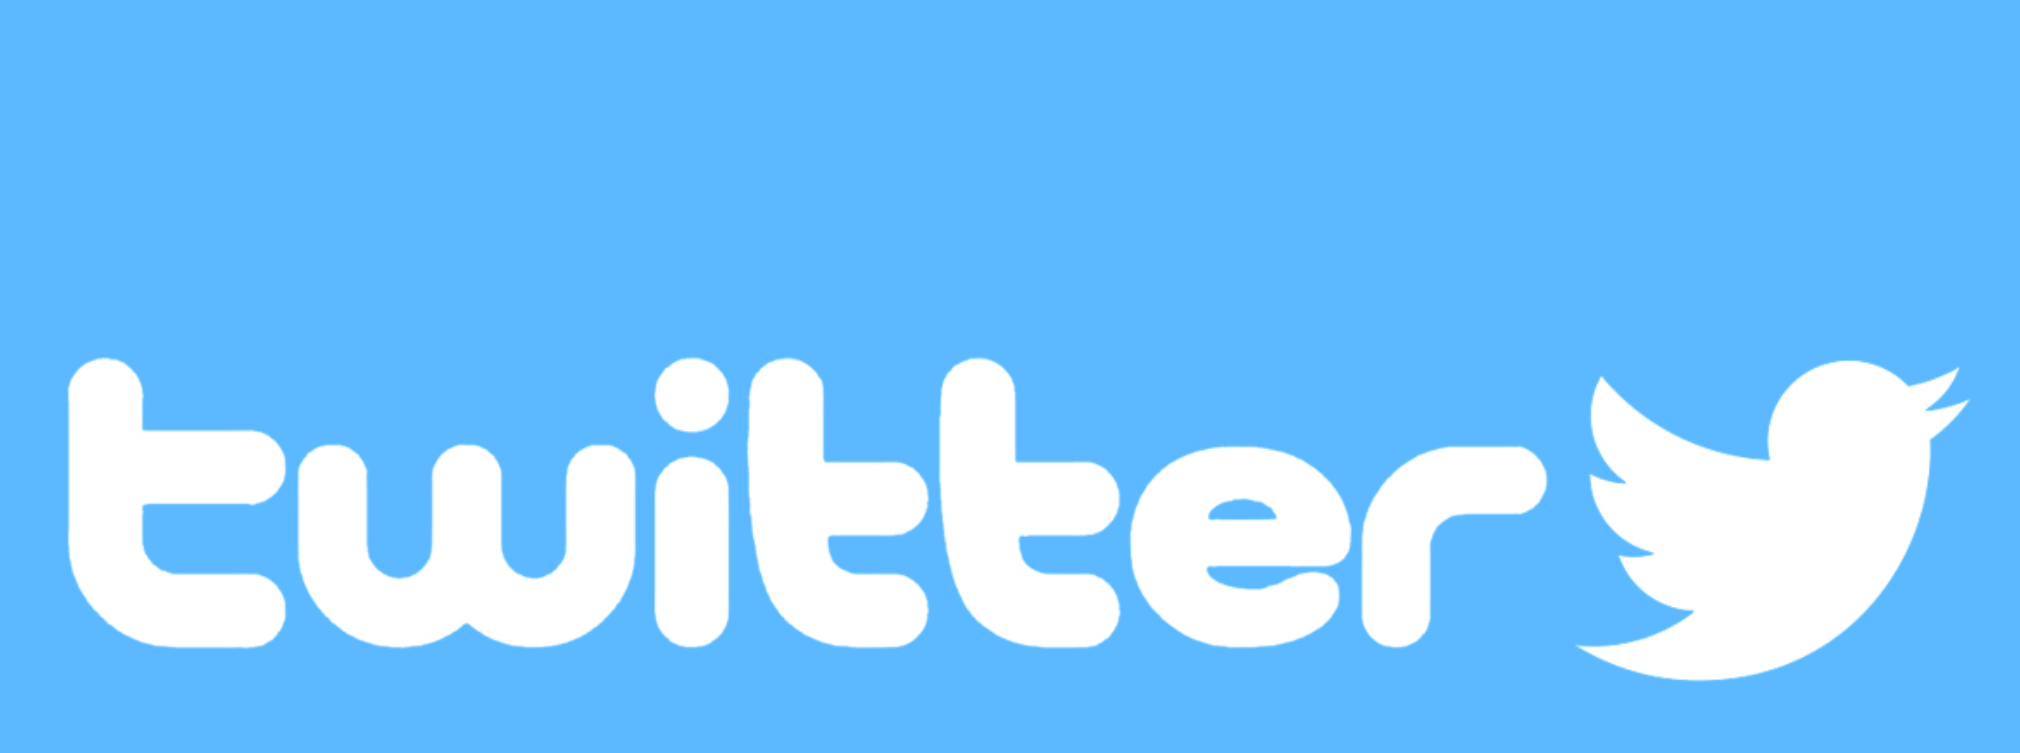

Kaggle Competition Link: https://www.kaggle.com/c/nlp-getting-started

Kaggle Competition Description:
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).
But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this challenge we will predicting whether a tweet is referring to a real disaster or not.


I would like to mention the following notebook for helping guide me along the way

https://www.kaggle.com/parvezsohail/tweets-disaster-using-transfer-learning

## Import Libraries

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

2.6.0


## Import Dataset

In [3]:
train_df = pd.read_csv("train.csv")
# train_df.head()

In [4]:
test_df = pd.read_csv("test.csv")
# test_df.head()

In [5]:
# sample_submission.csv
sample_submission =pd.read_csv("sample_submission.csv")
# sample_submission.head()

##EDA

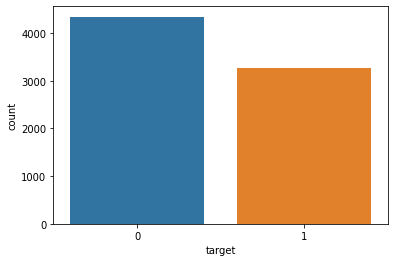

In [8]:
#check for the balance of data
sns.countplot(train_df['target'])

We can see here our data is not entirely misproportioned, but there are more tweets in our training dataset classified as not being related to a disaster.

In [9]:
# Check any null values
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

We have quite a few null values for "keyword" and "location". Kaggle gave us a warning on this in the challenge description. For now it's an interesting note, it might not be worth taking action because we will be tokenizing and embedding the tweets individually in their entirety.

In [10]:
#view top keywords for disaster
disaster_df = train_df[train_df['target'] == 1]
top_disaster_kw = disaster_df['keyword'].value_counts()
top_disaster_kw.head(10)

wreckage             39
derailment           39
outbreak             39
typhoon              37
debris               37
oil%20spill          37
suicide%20bomb       32
rescuers             32
evacuated            32
suicide%20bombing    32
Name: keyword, dtype: int64

All the words above are related to actual disasters in tweets. We can see here some special characters. Although, this is from the "keyword" column, we can assume that special characters will be in our tweets that maybe we should consider cleaning.

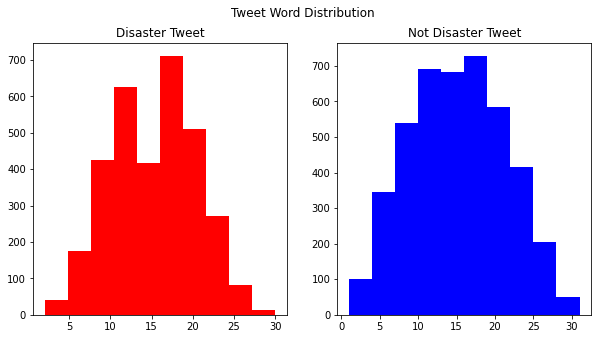

In [65]:
#view word distribution for tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_wc=train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_wc,color='red')
ax1.set_title('Disaster Tweet')
tweet_wc=train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_wc,color='blue')
ax2.set_title('Not Disaster Tweet')
fig.suptitle('Tweet Word Distribution')
plt.show()

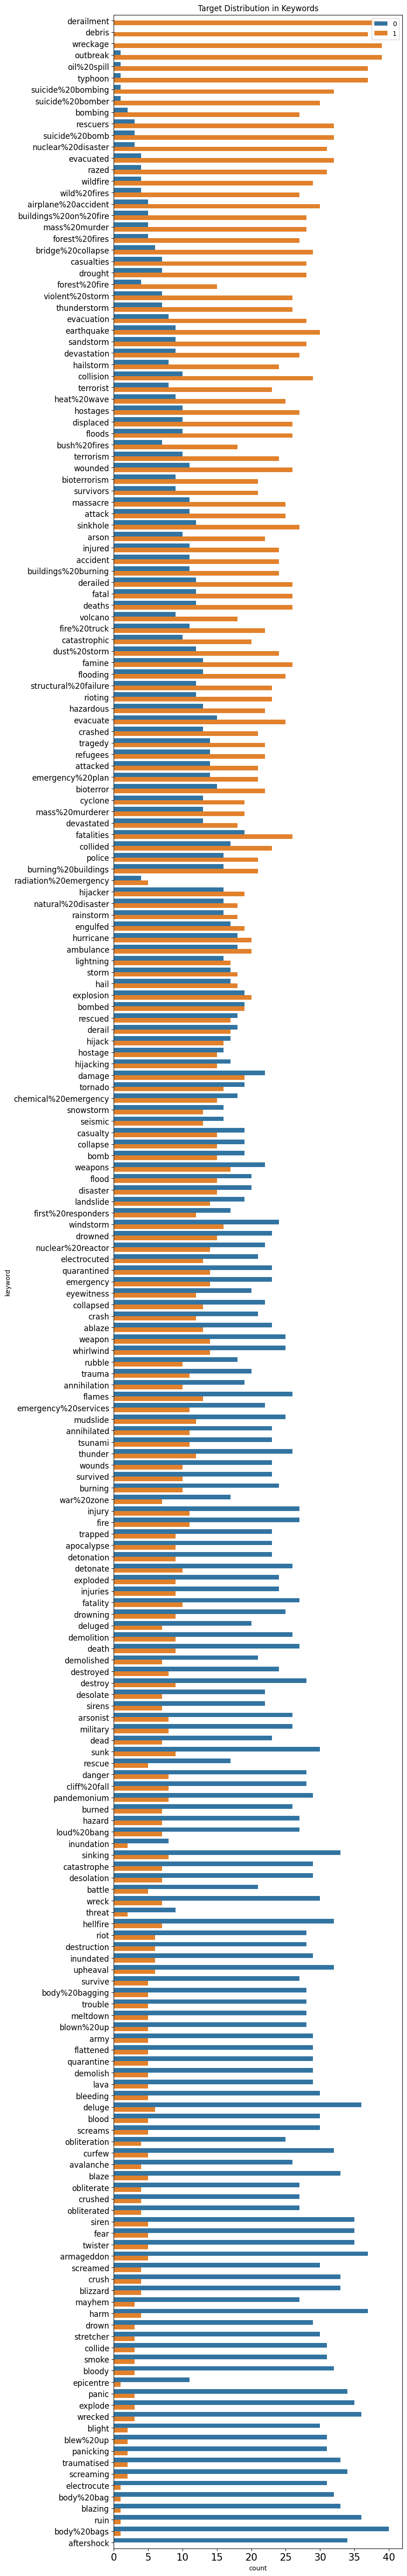

In [66]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df.drop(columns=['target_mean'], inplace=True)

One interesting insight from this is the keyword with a near even split between tweets that refer to a disaster and tweets that don't refer to a disaster is "bombed".

## Shuffle and Split

In [11]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
# train_df_shuffled

In [12]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                           train_df_shuffled['target'].to_numpy(),
                                                                           test_size=0.3,
                                                                           random_state=42)
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(5329, 2284, 5329, 2284)

In [13]:
# Average tokens
max_vocab_length =round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_vocab_length

15

## Tokenization and Embedding


In [14]:
# Create Tokenization Layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 10000

text_vectorization = TextVectorization(max_tokens=max_tokens,
                                      output_mode='int',
                                      output_sequence_length=max_vocab_length)

# fix the text vectorizer to the training set
text_vectorization.adapt(train_sentences)

In [15]:
# Check with sample_sentences
sample_sentences = "I'm in love with the shape of you We push and pull like a magnet do"
text_vectorization([sample_sentences])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  27,    4,  119,   14,    2, 1025,    6,   12,   47, 4017,    7,
        4023,   25,    3,    1]])>

In [16]:
# Check with random train sentences
import random
random_sentences  = random.choice(train_sentences)

print(f"Original Sentence : \n {random_sentences}\
      \n\nText_Vectorization : ")
text_vectorization([random_sentences])


Original Sentence : 
 I rate Hazard very highly but his fanboys are among the worst accounts on Twitter.      

Text_Vectorization : 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   8, 1121,  411,  547, 4576,   30,   75,    1,   21, 1295,    2,
         886, 5279,   11,  549]])>

In [17]:
# Create an Embedding Layer
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_tokens,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_vocab_length)

In [18]:
#check random
random_sentences = random.choice(train_sentences)
print(f"Original Sentences : \n{random_sentences}\
     \n\nEmbeddings : ")
embedding(text_vectorization([random_sentences]))

Original Sentences : 
I fail to see how that would not bring the number of road fatalities down IMMENSELY     

Embeddings : 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-3.74441519e-02, -3.23488005e-02,  4.04795893e-02, ...,
          2.18006410e-02,  7.54947588e-03,  1.14838257e-02],
        [ 2.61384360e-02, -2.23386418e-02,  3.31130736e-02, ...,
          3.79713662e-02, -4.77699637e-02,  3.03000100e-02],
        [-3.82184498e-02, -4.53354232e-02, -1.16092935e-02, ...,
          3.05705145e-03, -1.36214979e-02,  3.40643413e-02],
        ...,
        [-1.13336667e-02,  2.28003003e-02, -2.23888513e-02, ...,
          1.37458183e-02, -6.82822615e-03,  1.56049468e-02],
        [ 6.86161220e-05, -2.48723626e-02,  1.54362209e-02, ...,
         -2.06309557e-02, -2.62327082e-02, -1.52968243e-03],
        [ 3.44779529e-02,  1.81928612e-02,  1.22859590e-02, ...,
          2.99171098e-02, -3.49665880e-02,  4.76537682e-02]]],
      dtype=float32)>

In [19]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop1 = EarlyStopping(patience=5)
earlystop2 = ReduceLROnPlateau(monitor = 'val_accuracy', min_lr = 0.001,
 patience = 5)

## LSTM Model

In [96]:
# Pass the input layers
inputs = layers.Input(shape=(1,), dtype='string',name='input_shape')

# Pass the inputs to text vectorization layer
x = text_vectorization(inputs)

# Pass the text vectorization layer to embeddings
x = embedding(x)


# Build a model
# return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
# LSTM
x = layers.LSTM(units=32)(x)
# x = Bidirectional(layers.LSTM(300, dropout=0.3, recurrent_dropout=0.3))(x)

# Output Layer
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Pass the inputs and outputs to model
model = tf.keras.Model(inputs, outputs, name='model')

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy']
             )

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                20608     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Using GRU

# Pass the input layers
inputs = layers.Input(shape=(1,), dtype='string',name='input_shape')

# Pass the inputs to text vectorization layer
x = text_vectorization(inputs)

# Pass the text vectorization layer to embeddings
x = embedding(x)


# Build a model

# return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
# LSTM
x = layers.GRU(units=32)(x)

#

# Output Layer
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Pass the inputs and outputs to model
model = tf.keras.Model(inputs, outputs, name='model')

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy']
             )

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 32)                15552     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 1,295,585
Trainable params: 1,295,585
Non-trainable params: 0
_________________________________________________________________


In [21]:
# fit the model
history = model.fit(train_sentences, 
                   train_labels,
                   epochs=10,
                   validation_data=(val_sentences, val_labels),
                    callbacks=[earlystop1, earlystop2])

Epoch 1/10
167/167 [==============================] - 9s 9ms/step - loss: 0.5700 - accuracy: 0.6889 - val_loss: 0.4532 - val_accuracy: 0.7942
Epoch 2/10
167/167 [==============================] - 1s 6ms/step - loss: 0.3212 - accuracy: 0.8700 - val_loss: 0.4686 - val_accuracy: 0.7820
Epoch 3/10
167/167 [==============================] - 1s 6ms/step - loss: 0.1982 - accuracy: 0.9270 - val_loss: 0.5473 - val_accuracy: 0.7614
Epoch 4/10
167/167 [==============================] - 1s 6ms/step - loss: 0.1349 - accuracy: 0.9550 - val_loss: 0.6116 - val_accuracy: 0.7592
Epoch 5/10
167/167 [==============================] - 1s 6ms/step - loss: 0.1011 - accuracy: 0.9690 - val_loss: 0.7058 - val_accuracy: 0.7618
Epoch 6/10
167/167 [==============================] - 1s 6ms/step - loss: 0.0819 - accuracy: 0.9754 - val_loss: 0.7151 - val_accuracy: 0.7526


In [24]:
# plot loss curves
def plot_loss_curves(history):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(history.history['loss']))
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.title("Loss")
    plt.plot(epochs, loss, label='loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.title("Accuracy")
    plt.plot(epochs, accuracy, label='accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.xlabel("Epochs")
    plt.legend()

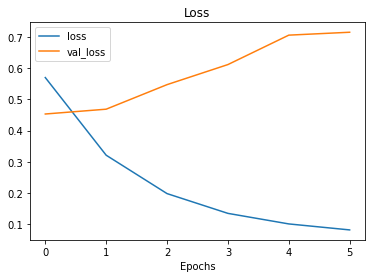

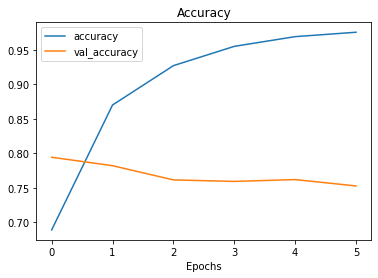

In [25]:
plot_loss_curves(history=history)

#also can post to the discussion

From the graphs above, our model is overfitting. If we wanted to reduce overfitting, we could try adding dropout layers, changing the optimizer, L1L2 regularization, statistically balance our dataset, or other regularization techniques for our model.

In [29]:
# preds_probs
model_pred_probs = model.predict(val_sentences)
# model_pred_probs

In [28]:
# initial predictions
model_preds = tf.squeeze(tf.round(model_pred_probs))
# model_preds

In [30]:
# evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_preds):
    
    # model_accuracy
    model_accuracy = accuracy_score(y_true, y_preds)* 100
    # calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_preds, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

In [31]:
model_1_results = calculate_results(val_labels, model_preds)
model_1_results

{'accuracy': 75.26269702276707,
 'f1': 0.7525686954829737,
 'precision': 0.7525176649901462,
 'recall': 0.7526269702276708}

## Transfer Learning

In [32]:
# import tensorflow hub
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[], # shape of inputs coming to our model
                                       dtype=tf.string,
                                       trainable=False)

Tensorflow hub states this layer is common for classification, so this encoding layer could help us achieve a higher score than the GRU model we already created. You can learn more about this layer from the above link.

In [33]:
# Create model using the Sequential API
model_2 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
],name='USE')

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [35]:
history_2 = model_2.fit(train_sentences,
                       train_labels,
                       epochs=10,
                       validation_data=(val_sentences, val_labels),
                        callbacks=[earlystop1, earlystop2])


Epoch 1/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3795 - accuracy: 0.8362 - val_loss: 0.4281 - val_accuracy: 0.8095
Epoch 2/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3745 - accuracy: 0.8369 - val_loss: 0.4281 - val_accuracy: 0.8113
Epoch 3/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3691 - accuracy: 0.8379 - val_loss: 0.4393 - val_accuracy: 0.8104
Epoch 4/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3643 - accuracy: 0.8390 - val_loss: 0.4282 - val_accuracy: 0.8148
Epoch 5/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3588 - accuracy: 0.8411 - val_loss: 0.4277 - val_accuracy: 0.8130
Epoch 6/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3540 - accuracy: 0.8431 - val_loss: 0.4334 - val_accuracy: 0.8087
Epoch 7/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3474 - accuracy: 0.8444 - val_loss: 0.4304 - val_accuracy: 0.8139

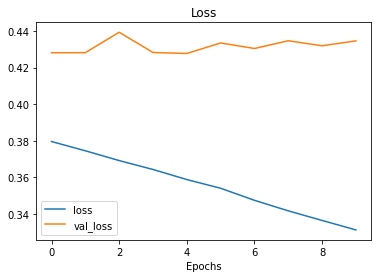

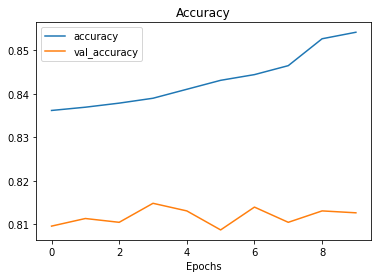

In [37]:
# plot_loss_curves
plot_loss_curves(history_2)

In [43]:
# make prediction probabilities
model_2_prediction_probs = model_2.predict(val_sentences)
# model_2_prediction_probs[:10]

In [44]:
# prediction 
model_2_preds = tf.squeeze(tf.round(model_2_prediction_probs))
# model_2_preds[:10]

In [46]:
# Calculate results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 81.26094570928196,
 'f1': 0.8112356112544626,
 'precision': 0.8135977205934304,
 'recall': 0.8126094570928196}

In [47]:
#Next transfer learning model
wiki_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-250-with-normalization/2",
                                       input_shape=[], # shape of inputs coming to our model
                                       dtype=tf.string,
                                       trainable=False)



I didn't do much preprocessing for the text in tweets, so adding this layer instead might increase our accuracy. This layer is token based text embedding and was trained on an english wikipedia corpus. It also has normalization, which will help clean our text a little bit.

In [48]:
# Create model using the Sequential API
model_3 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
],name='USE')

# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [50]:
history_3 = model_3.fit(train_sentences,
                       train_labels,
                       epochs=10,
                       validation_data=(val_sentences, val_labels), 
                        callbacks=[earlystop1, earlystop2])

#marginally bettwer with .8065

Epoch 1/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3813 - accuracy: 0.8351 - val_loss: 0.4286 - val_accuracy: 0.8069
Epoch 2/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3742 - accuracy: 0.8399 - val_loss: 0.4297 - val_accuracy: 0.8060
Epoch 3/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3677 - accuracy: 0.8384 - val_loss: 0.4302 - val_accuracy: 0.8087
Epoch 4/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3628 - accuracy: 0.8418 - val_loss: 0.4310 - val_accuracy: 0.8091
Epoch 5/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3572 - accuracy: 0.8429 - val_loss: 0.4305 - val_accuracy: 0.8117
Epoch 6/10
167/167 [==============================] - 2s 13ms/step - loss: 0.3512 - accuracy: 0.8444 - val_loss: 0.4325 - val_accuracy: 0.8126


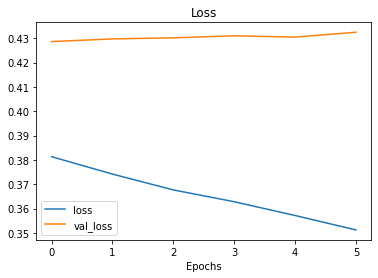

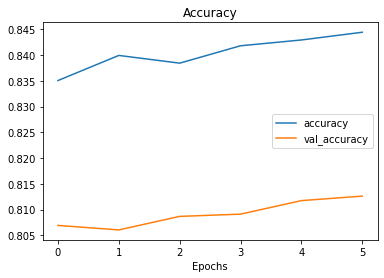

In [53]:
plot_loss_curves(history_3)

In [54]:
# make prediction probabilities
model_3_prediction_probs = model_3.predict(val_sentences)
# model_3_prediction_probs[:10]

In [55]:
# prediction 
model_3_preds = tf.squeeze(tf.round(model_3_prediction_probs))
# model_3_preds[:10]

In [56]:
# Calculate results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 81.26094570928196,
 'f1': 0.8112692099611041,
 'precision': 0.8135258510396086,
 'recall': 0.8126094570928196}

##Submission


In [57]:
test_sentences = test_df['text'].to_list()
test_sentences[:10]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 "We're shaking...It's an earthquake",
 "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
 'Hey! How are you?',
 'What a nice hat?',
 'Fuck off!']

In [58]:
# Making predictions on the test dataset

# Keep all the sentences in a list
test_sentences = test_df["text"].to_list()
# take random sample from the list upto 10 samples
test_samples = random.sample(test_sentences, 10)
# loop through to test_samples
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_3.predict([test_sample])) # has to be list
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")



Pred: 0, Prob: 0.045065391808748245
Text:
@lizjillies it's such a tongue twister

----

Pred: 1, Prob: 0.6186017394065857
Text:
@asgharchohan86 @AdilGhumro 
There are floods in kpk because you guys couldn't build dams in 30 years you ruled.
Even for your own Thar

----

Pred: 0, Prob: 0.3143942356109619
Text:
About to get it with the babes of #wildfire and @taviiikenney of course!!

----

Pred: 0, Prob: 0.18788115680217743
Text:
I made him fall and hegot injured https://t.co/XX8RO94fBC

----

Pred: 1, Prob: 0.9616643786430359
Text:
Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/kZYvMnqHy7 via @Reuters

----

Pred: 0, Prob: 0.25151899456977844
Text:
if this fucking is true i will be decapitated and throw my head into a avalanche  https://t.co/4cw6Nmmw1O

----

Pred: 0, Prob: 0.04350095987319946
Text:
@disneyxrowbrina the ambulance isn't even parked well like its nearly on top of someone's car I'm laughing

----

Pred: 0, Prob: 0.15562544763088226
Text:

In [59]:
prediction_probs  = model_3.predict([test_df['text']])
prediction_probs

array([[0.61288327],
       [0.94654113],
       [0.81647533],
       ...,
       [0.95598286],
       [0.6032326 ],
       [0.7185018 ]], dtype=float32)

In [60]:
predictions = tf.squeeze(tf.round(prediction_probs))
predictions

<tf.Tensor: shape=(3263,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [61]:
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = predictions

In [62]:
submission

,id,target
0,0,1.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0
...,...,...
3258,10861,1.0
3259,10865,1.0
3260,10868,1.0
3261,10874,1.0


In [63]:
#change for Kaggle formatting
print(submission.dtypes)
#change target to int
submission['target'] = submission['target'].astype(int)
submission.dtypes

id          int64
target    float32
dtype: object


id        int64
target    int64
dtype: object

In [64]:
submission.to_csv("submission5.csv", index=False)